In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageH

In [4]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "bias": {}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [5]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*20, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    #"aberrations": opt(g*100,20),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
    "bias": opt(g*30, 20)
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [6]:
losses, models = optimise(params, model_single, exposures_single, things, 30)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[4121683.77209685, -679897.209866  ],
       [-679897.209866  , 4092886.00814989]], dtype=float64), 'spectrum': Array([[39826454.79231571,  -395507.82924534, 14555262.43270589,
         -203723.15280849,  9614409.21285834],
       [ -395507.82924534,  4865546.00549563,  -219745.23101504,
         3097058.37731791,  -170903.77981541],
       [14555262.43270589,  -219745.23101504,  6592743.60585594,
         -130493.44404749,  4699172.63873168],
       [ -203723.15280849,  3097058.37731791,  -130493.4440475 ,
         2330108.18960466,  -104008.61097634],
       [ 9614409.21285834,  -170903.77981541,  4699172.63873168,
         -104008.61097634,  3518460.47781109]], dtype=float64), 'cold_mask_shift': Array([[-80769.82266116,   9609.93435872],
       [  9609.93435872, -80660.72599758]], dtype=float64), 'cold_mask_rot': Array([[-145903.98487203]], dtype=float64), 'bias': Array([[8218081.95721834]], dtype=float64)}}
Fitting Model


  0%|          | 0/30 [00:00<?, ?it/s]

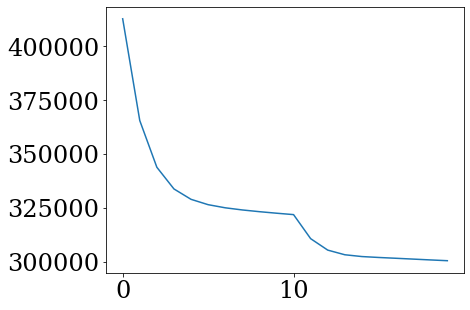

In [7]:
plt.plot(losses[-20:])

5


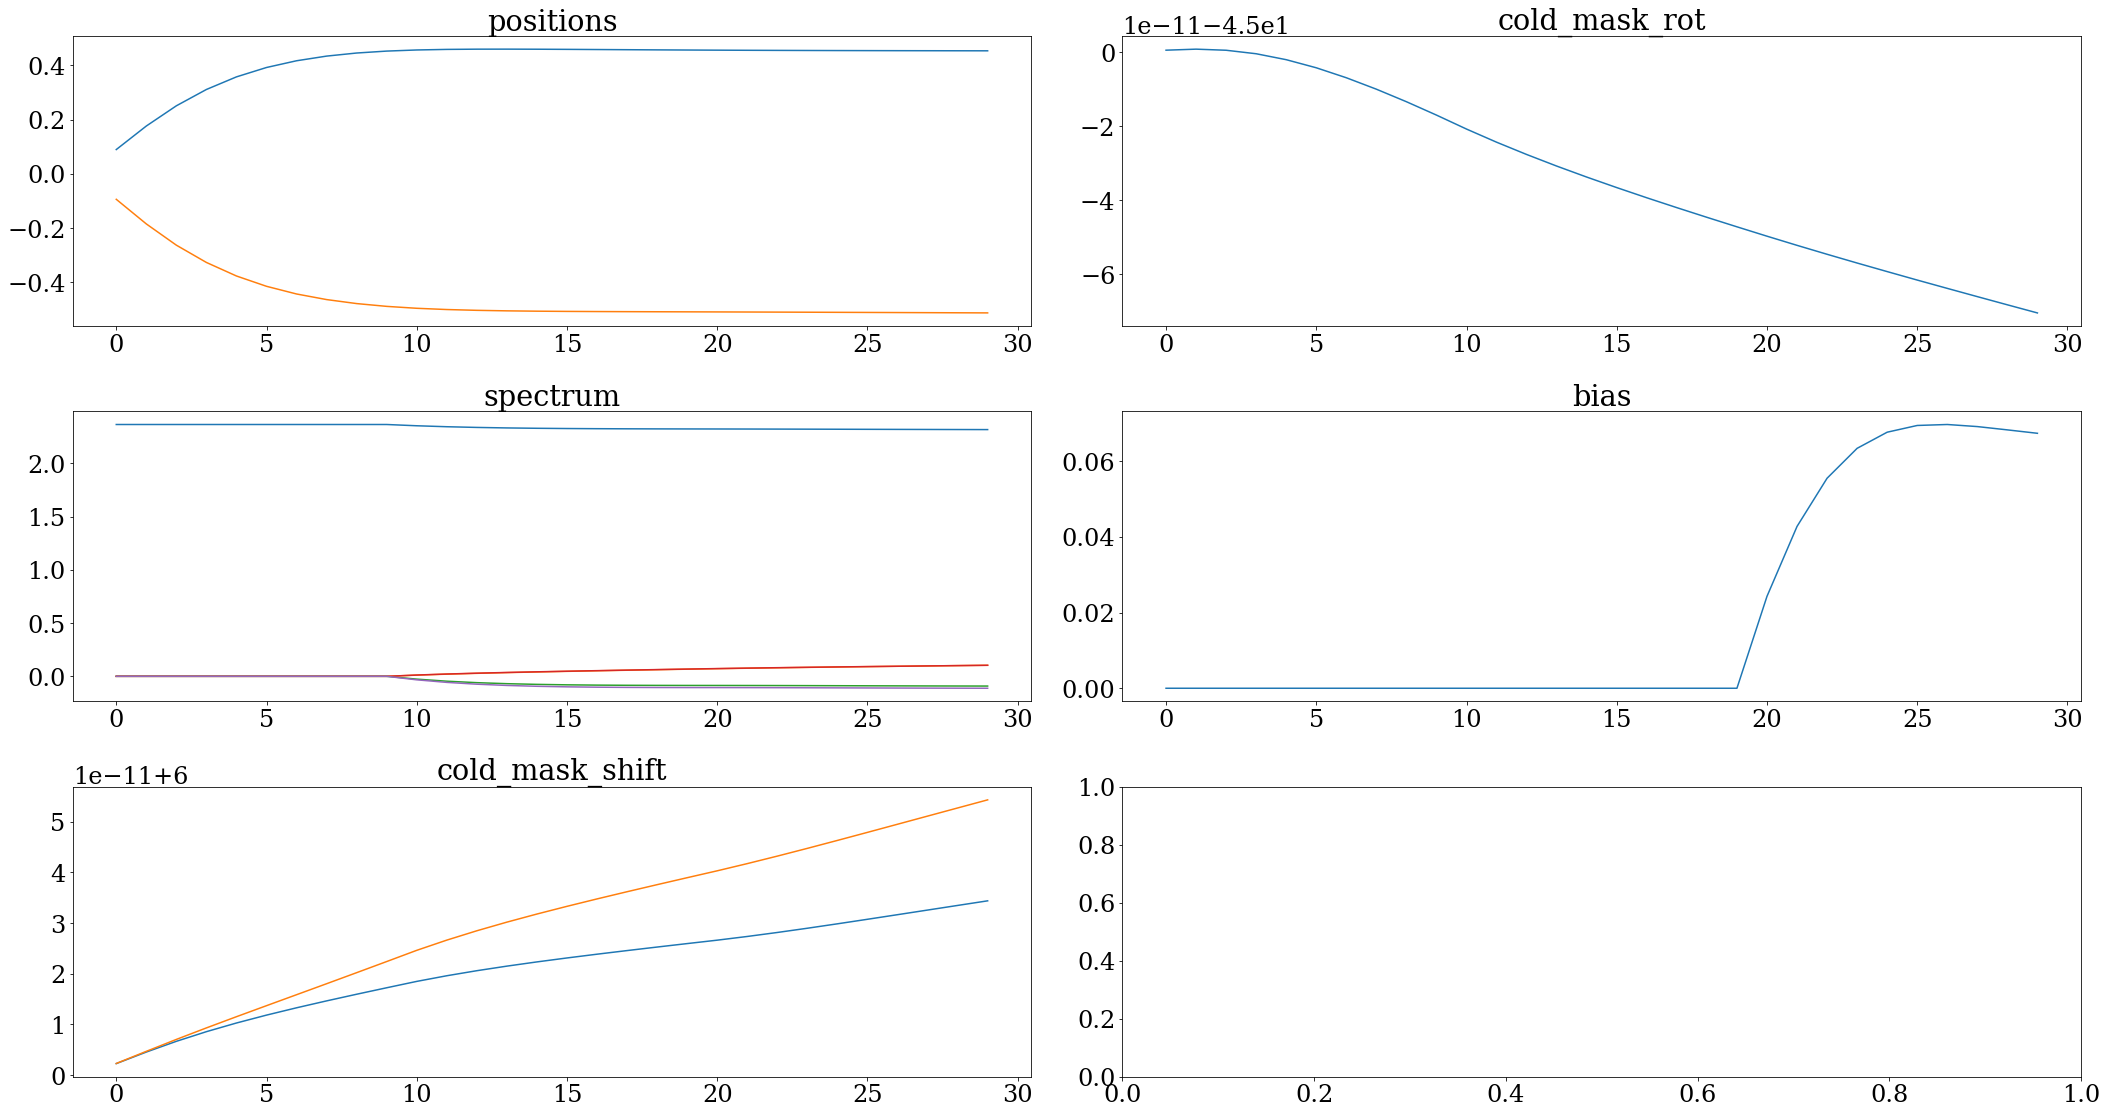

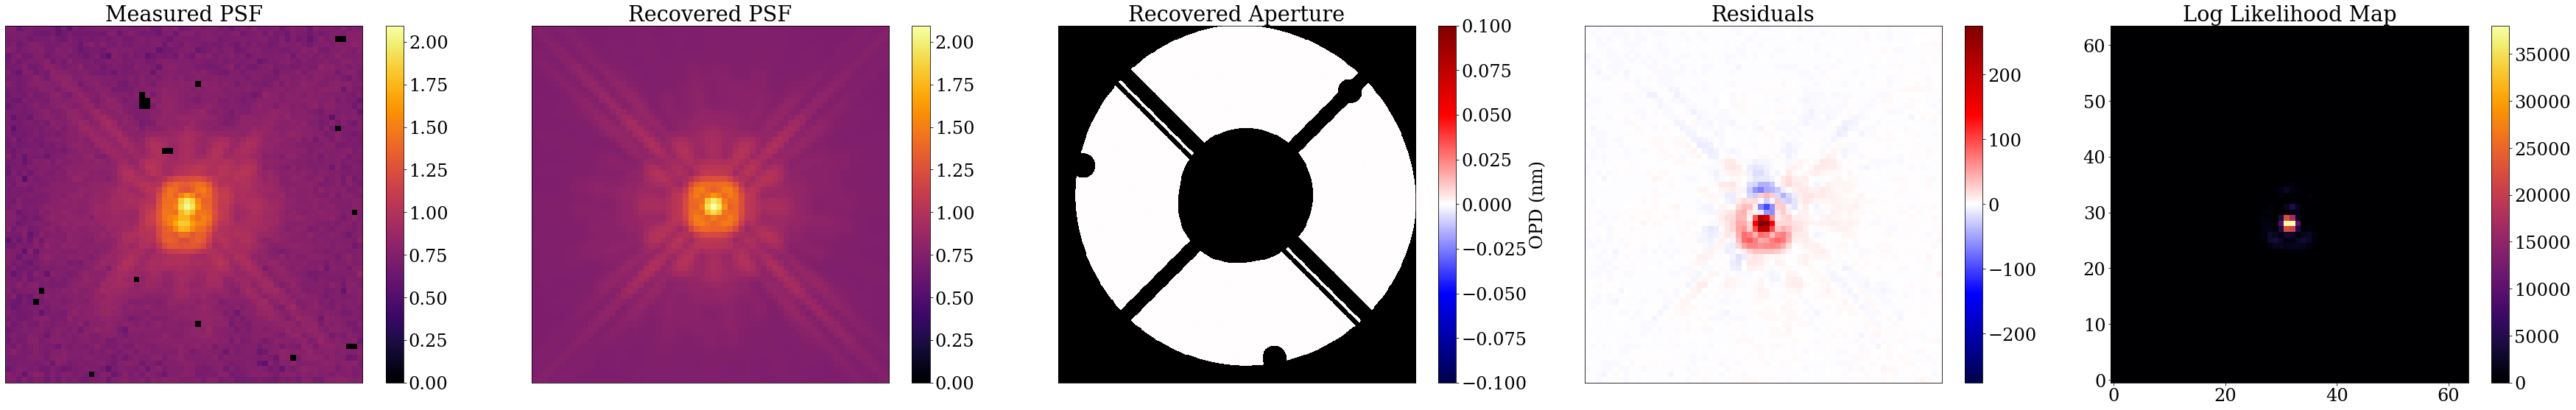

In [8]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [9]:
#potato

In [10]:
#plot_spectra(model_single, models[-1], exposures_single)

In [11]:
def tree_mul(spec, val):
    return jtu.tree_map(lambda x: x*val, spec)

def tree_sum(spec, val):
    return jtu.tree_map(lambda x: x+val, spec)


def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = tree_sum(param_dict["positions"], np.array([x,y]))
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)


"""def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):
    fluxes = dlu.fluxes_from_contrast(flux, contrast)
    injected_params = ModelParams({
        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),
        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),
        "positions": np.asarray([x,y]),
        "position_angle": theta,
        "separation": r
    })
    return injected_params.inject(initial_params)
"""

'def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):\n    fluxes = dlu.fluxes_from_contrast(flux, contrast)\n    injected_params = ModelParams({\n        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),\n        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),\n        "positions": np.asarray([x,y]),\n        "position_angle": theta,\n        "separation": r\n    })\n    return injected_params.inject(initial_params)\n'

In [12]:
binary_params = extract_binary_params(models[-1], exposures_binary, 0., 0., 0., 0., 0., 1.)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [13]:
@zdx.filter_jit
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [14]:
#jax.profiler.start_server(1234)

In [15]:
#with jax.profiler.trace("/tmp/tensorboard"):
#    x = loss_fn(params, exposures_single, model_single)
#    x.block_until_ready()


In [16]:
#stop

In [17]:

@zdx.filter_jit
def fit_binary_flux(params, exposures, x, y, theta, r, contrast):
    base_params = extract_binary_params(params, exposures, x, y, theta, r, 0., contrast)

    mdl = params.inject(model_binary)

    
    mean_flux = 0.

    for exp in exposures:

        #print(params.params["spectrum"])

        spec = params.get(exp.fit.map_param(exp, "spectrum"))[0]
        #print(spec)

        psf = exp.fit(mdl,exp).flatten()
        psf= np.where(exp.bad.flatten(), 0., psf)

        psf = psf/np.sum(psf)
        #psf.at[exp.bad.flatten()].set(0.)

        data = exp.data.flatten()
        #data= data.at[exp.bad.flatten()].set(0.)
        data= np.where(exp.bad.flatten(), 0., data)


        design = np.transpose(np.vstack((np.ones(len(psf)), psf)))

        flux_raw, _, _, _ = np.linalg.lstsq(design, data)
        
        true_flux= np.log10(flux_raw[1]/nwavels * 2/(1+contrast)) - spec
        #print(true_flux)

        mean_flux += true_flux/len(exposures)
    
    flux_params = extract_binary_params(params, exposures, x, y, theta, r, mean_flux, contrast)

    return loss_fn(flux_params, exposures, model_binary), flux_params  



In [18]:
binary_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f64[26]},
    'bias':
    {'n8yj59glq': f64[]},
    'cold_mask_rot':
    {'n8yj59glq': f64[]},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'cold_mask_shift':
    {'n8yj59glq': f64[2]},
    'outer_radius':
    1.146,
    'positions':
    {'n8yj59glq': f64[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_shear':
    {'F110W': f64[2]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f64[5]},
    'spider_width':
    0.0924,
    'primary_spectrum':
    {'U20081_F110W': f64[5]},
    'secondary_spectrum':
    {'U20081_F110W': f64[5]},
    'fluxes':
    {'U20081_F110W': 0.0},
    'contrast':
    {'F110W': 1.0},
    'separation':
    0.0,
    'position_angle':
    0.0
  }
)

In [19]:
#x_vals = np.linspace(-5, 5, 4)
theta_vals = 360* np.arange(8)/8#np.arange(4)*np.pi/2#np.linspace(0, 2*np.pi, 4)
r_vals = np.arange(20)/2#np.linspace(0,15,20)#np.asarray([1.5, 3])#np.linspace(0, 5, 2)
contrast_vals = [1.]#10**np.linspace(-1, 1, 21)
min_loss = np.inf
best_params = None

#for x in x_vals:
    #for y in y_vals:
for theta in theta_vals:
    for r in r_vals:
        for cnt in contrast_vals:
            ang = dlu.deg2rad(theta)
            x = -r*np.sin(ang)/2
            y = -r*np.cos(ang)/2
            #print(dlu.positions_from_sep(np.asarray([x,y]), r, theta))
            loss, params = fit_binary_flux(models[-1], exposures_binary, x, y, theta, r, cnt)

            print(loss)
            if loss < min_loss and min_loss != 0.0:
                min_loss = loss
                best_params = params
        

870147.9360181777
927559.8615466844
1042570.1511048245
1160054.1973901116
1174325.7836122622
1002871.2700064464
832554.1543084799
1053399.7174184776
2139214.869637458
4461176.781412866
7807383.00383685
11441676.59928927
14309716.38044294
15993034.148504825
18604993.21086915
25786363.451802906
40640794.897911966
63494797.590271235
86828565.02844903
101422122.04369049
870147.9360181777
957500.5031589956
1251238.4446350513
1800909.1675769622
2431069.9807722946
2805988.243014875
2931397.654031125
3232532.9480347396
4087278.1236262335
5597249.486573332
7697553.130471638
10343941.285654932
13812646.462718064
19062738.440579183
27668129.145980675
40711775.322347045
57342773.13176767
74686606.63804755
89490413.92420915
100627670.70080452
870147.9360181777
1011866.0637853044
1578050.8152761937
2707609.4772421136
4090427.5240237443
5239220.785861729
6019692.078010693
6762940.891003508
8498778.981928136
12838015.553451147
21751667.488459684
35805974.28993716
50877956.62419459
62122783.220341064
7

In [20]:
best_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f64[26]},
    'bias':
    {'n8yj59glq': f64[]},
    'cold_mask_rot':
    {'n8yj59glq': f64[]},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'cold_mask_shift':
    {'n8yj59glq': f64[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f64[]},
    'outer_radius':
    1.146,
    'position_angle':
    f64[],
    'positions':
    {'n8yj59glq': f64[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_shear':
    {'F110W': f64[2]},
    'primary_spectrum':
    {'U20081_F110W': f64[5]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f64[5]},
    'separation':
    f64[],
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f64[5]},
    'spider_width':
    0.0924
  }
)

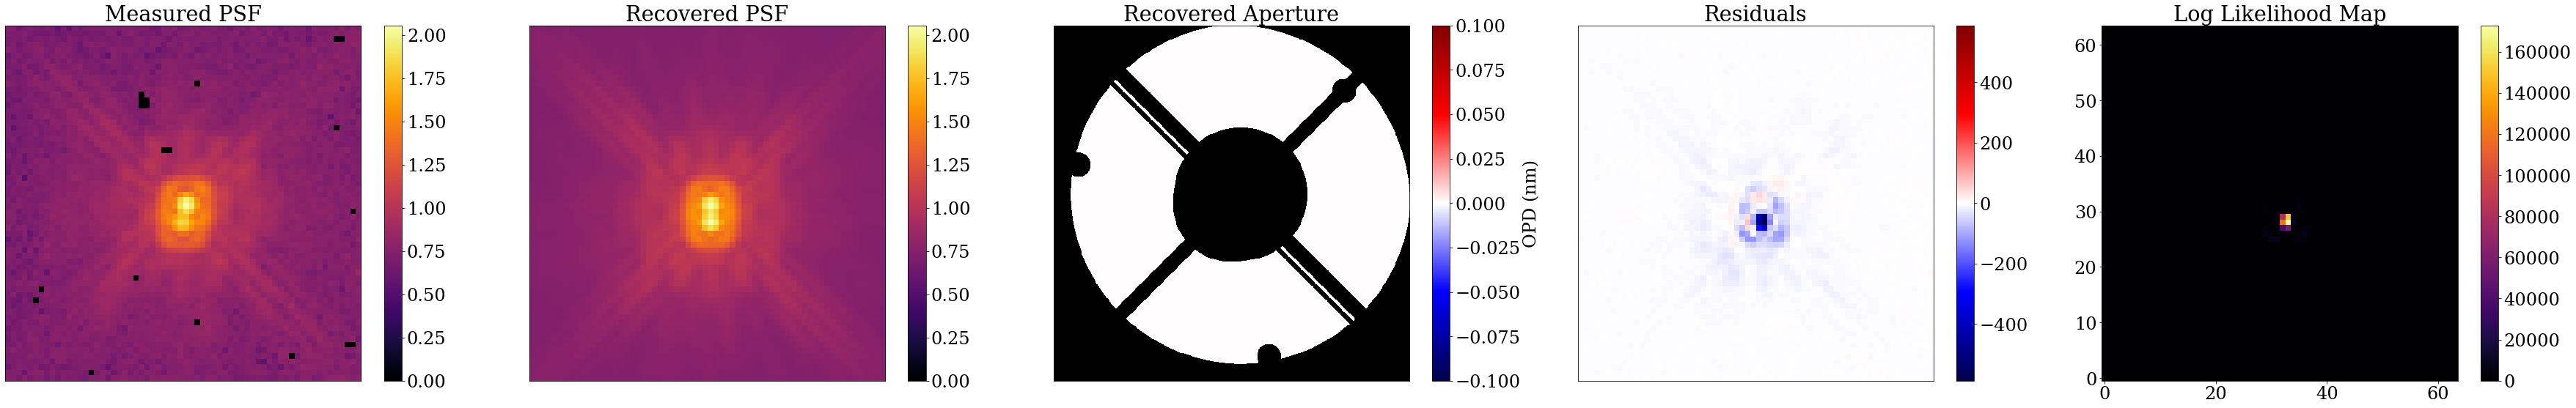

In [21]:
plot_comparison(model_binary, best_params, exposures_binary)

In [22]:
g = 5e-3
things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*100, 0),
    "separation": opt(g*30, 0),
    "position_angle": opt(g*1e-2, 10),
    "primary_spectrum": opt(g*50, 20),
    "secondary_spectrum": opt(g*50, 20),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 60),
    "cold_mask_rot": opt(g*10, 60),
    "aberrations": opt(g*10,30),#, (150, g*0.2)),
    "bias": opt(g*20, 40)
}
groups = list(things.keys())


In [23]:
losses, models = optimise(best_params, set_array(model_binary), exposures_binary, things, 150)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[6871236.56921182, -300895.60726759],
       [-300895.60726759, 5537712.41984667]], dtype=float64), 'separation': Array([[-404355.87783963]], dtype=float64), 'position_angle': Array([[0.]], dtype=float64), 'primary_spectrum': Array([[27912387.21291791,  2834961.77385361,  9143671.31681897,
         2016060.51671291,  5739870.09145991],
       [ 2834961.7738536 ,  5051666.76977997,  1459064.33382615,
         3120086.27224176,  1090387.15730177],
       [ 9143671.31681897,  1459064.33382615,  4390292.72279127,
         1137864.58622771,  3145706.92330094],
       [ 2016060.51671291,  3120086.27224176,  1137864.58622771,
         2331353.51346262,   905736.19716849],
       [ 5739870.09145991,  1090387.15730177,  3145706.92330094,
          905736.19716849,  2436097.59229562]], dtype=float64), 'secondary_spectrum': Array([[27912387.21291791,  2834961.77385361,  9143671.31681897,
         2016060.51671291,  5739870.09145991],
       [ 2834961.7738536 ,  

  0%|          | 0/150 [00:00<?, ?it/s]

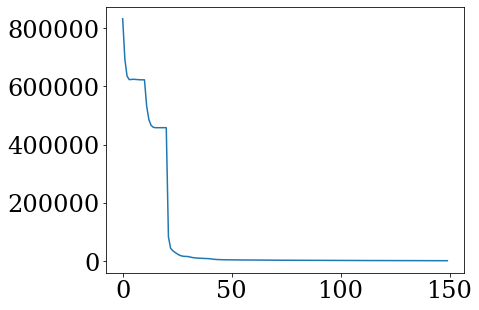

In [24]:
plt.plot(losses)

In [25]:
losses[-1]

Array(1536.16488853, dtype=float64)

9


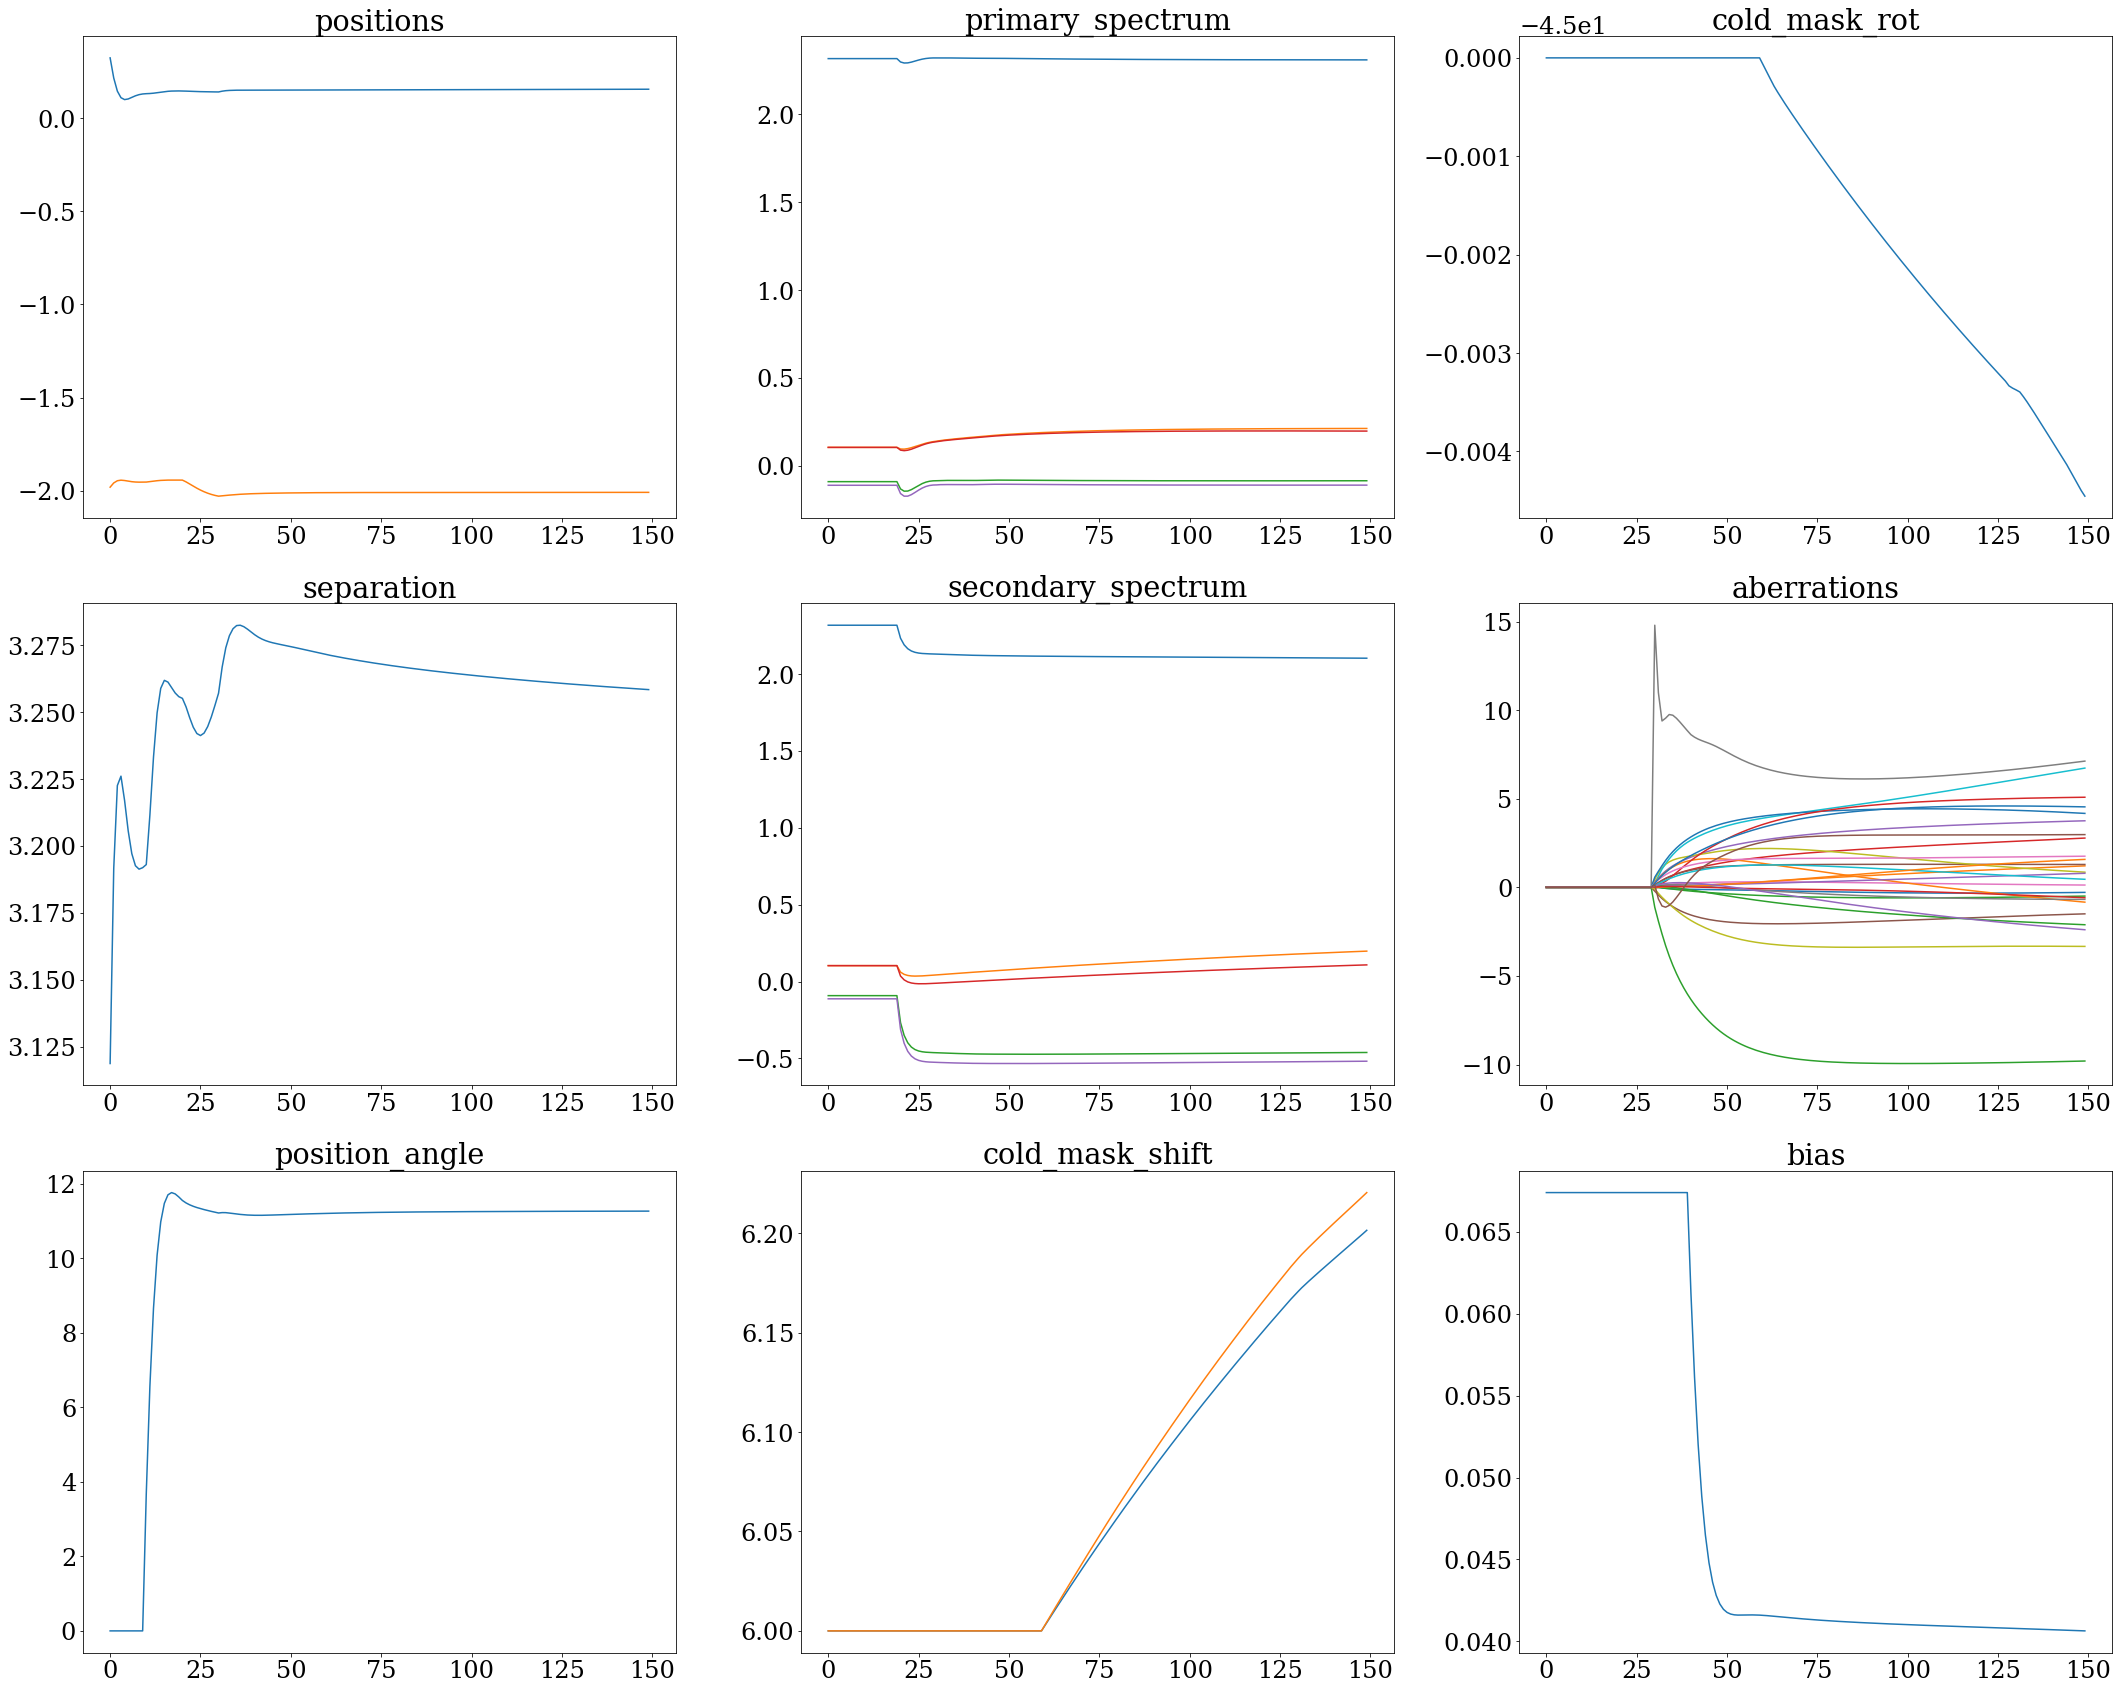

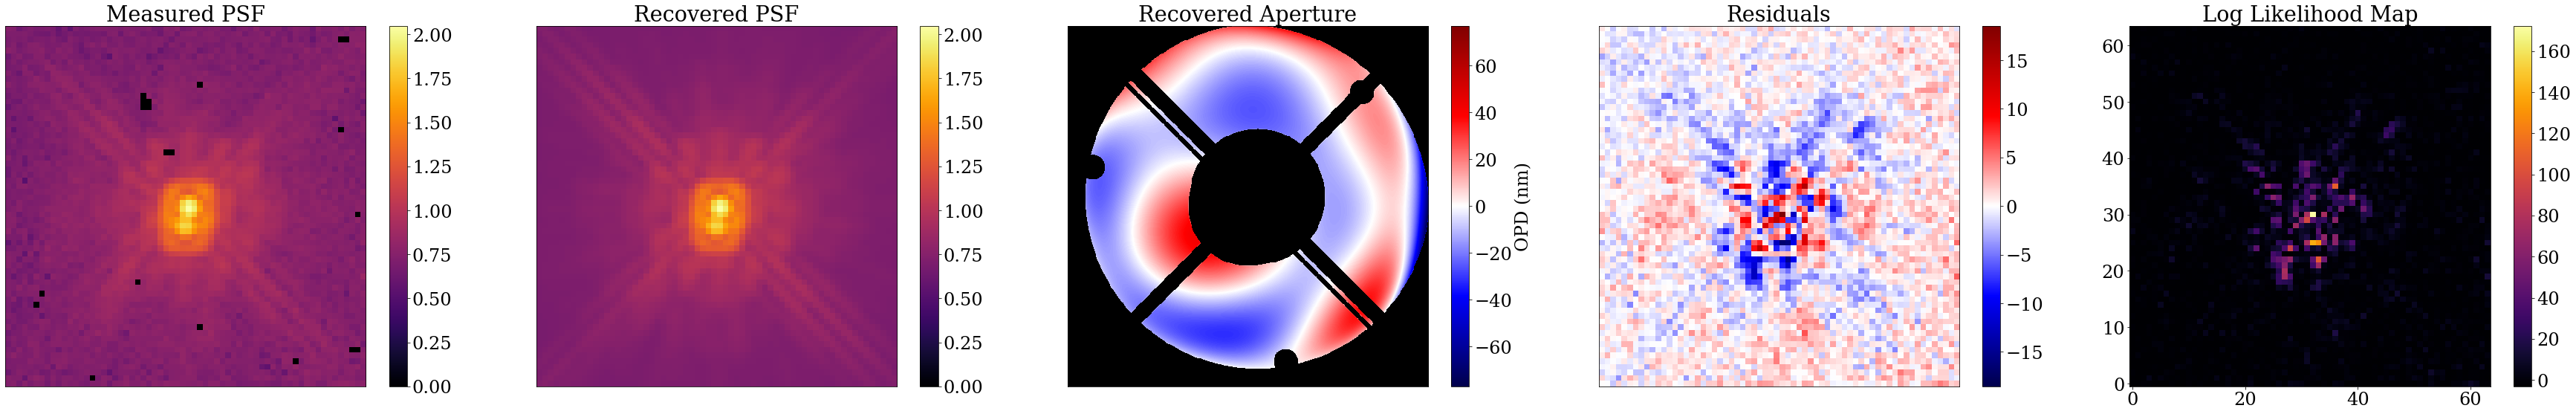

In [26]:
plot_params(models, groups, xw = 3)
plot_comparison(model_binary, models[-1], exposures_binary)

In [27]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([-0.28655324,  1.20978711, -0.4956152 ,  2.77849912,  3.75421992,
          1.28945923,  0.12800081,  7.12206562,  0.8539062 ,  6.72796763,
          4.17137135, -0.83774013, -9.80358083,  5.08357224,  0.79123583,
         -1.49785785,  1.75557233, -0.68158536, -3.33493122,  0.45254949,
          4.5400707 ,  1.57537228, -2.11188298, -0.58871801, -2.39430867,
          2.97432904], dtype=float64)},
 'bias': {'n8yj59glq': Array(0.04064342, dtype=float64)},
 'cold_mask_rot': {'n8yj59glq': Array(-45.00445415, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8yj59glq': Array([6.20151177, 6.22047924], dtype=float64)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.08427543, dtype=float64))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.26706172, dtype=float64),
 'positions': {'n8yj59glq

Text(0, 0.5, 'Relative Spectral Intensity')

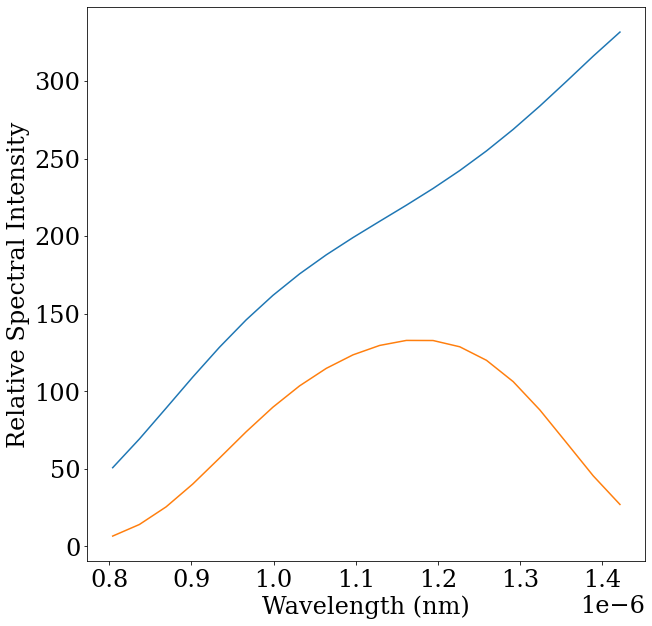

In [28]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [29]:
rc = True
fishers = calc_fishers(models[-1].inject(model_binary), exposures_binary, groups, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [30]:
fishers

{'n8yj59glq': {'positions': Array([[1909481.16081624,  -71974.71314693],
         [ -71974.71314693, 1665972.05755616]], dtype=float64),
  'separation': Array([[456567.27662979]], dtype=float64),
  'position_angle': Array([[1513.54828772]], dtype=float64),
  'primary_spectrum': Array([[10279050.07067245,  2440890.12427078,  3679463.58528967,
           1670665.78935134,  2410767.04980965],
         [ 2440890.12427078,   808309.6566634 ,   921096.69336599,
            506389.16773329,   604412.1404304 ],
         [ 3679463.58528967,   921096.69336599,  1344234.70334849,
            623669.332661  ,   882079.26626836],
         [ 1670665.78935134,   506389.16773329,   623669.332661  ,
            325913.72197278,   409460.61549093],
         [ 2410767.04980965,   604412.1404304 ,   882079.26626836,
            409460.61549093,   579087.81255061]], dtype=float64),
  'secondary_spectrum': Array([[3176009.10592916,  303932.47298434,  662206.39349275,
           159352.962136  ,  317361.3635

In [31]:
aberration_names = [dlu.zernike_name(x) for x in range(40)]
poly_names = ["poly "+ x for x in ["0", "1", "2", "3", "4"]]

In [32]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([-0.28655324,  1.20978711, -0.4956152 ,  2.77849912,  3.75421992,
          1.28945923,  0.12800081,  7.12206562,  0.8539062 ,  6.72796763,
          4.17137135, -0.83774013, -9.80358083,  5.08357224,  0.79123583,
         -1.49785785,  1.75557233, -0.68158536, -3.33493122,  0.45254949,
          4.5400707 ,  1.57537228, -2.11188298, -0.58871801, -2.39430867,
          2.97432904], dtype=float64)},
 'bias': {'n8yj59glq': Array(0.04064342, dtype=float64)},
 'cold_mask_rot': {'n8yj59glq': Array(-45.00445415, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8yj59glq': Array([6.20151177, 6.22047924], dtype=float64)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.08427543, dtype=float64))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.26706172, dtype=float64),
 'positions': {'n8yj59glq

In [33]:
new_params = ModelParams({"separation": 12.})

In [34]:
ModelParams(models[-1].params | new_params.params).params

{'aberrations': {'n8yj59glq': Array([-0.28655324,  1.20978711, -0.4956152 ,  2.77849912,  3.75421992,
          1.28945923,  0.12800081,  7.12206562,  0.8539062 ,  6.72796763,
          4.17137135, -0.83774013, -9.80358083,  5.08357224,  0.79123583,
         -1.49785785,  1.75557233, -0.68158536, -3.33493122,  0.45254949,
          4.5400707 ,  1.57537228, -2.11188298, -0.58871801, -2.39430867,
          2.97432904], dtype=float64)},
 'bias': {'n8yj59glq': Array(0.04064342, dtype=float64)},
 'cold_mask_rot': {'n8yj59glq': Array(-45.00445415, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8yj59glq': Array([6.20151177, 6.22047924], dtype=float64)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.08427543, dtype=float64))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.26706172, dtype=float64),
 'positions': {'n8yj59glq

In [35]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0]

Array(0.02570407, dtype=float64)

In [36]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0]

Array(0.00147995, dtype=float64)

In [37]:
np.diag(np.sqrt(np.linalg.inv(fishers['n8yj59glq']['primary_spectrum'])))

Array([0.00292739, 0.01410042, 0.05542002, 0.03042627, 0.07866348],      dtype=float64)

In [44]:
def init_array_from_params(params):
    init_array = {}
    exp = exposures_binary[0]
    pos_mean = params.get(exp.map_param("positions"))
    init_array["X"] = pos_mean[0]
    init_array["Y"] = pos_mean[1]

    position_angle = params.get("position_angle")
    init_array["Position Angle"] = position_angle
    separation = params.get("separation")
    init_array["Separation"] = separation

    primary_spectrum = params.get(exp.map_param("primary_spectrum"))
    secondary_spectrum = params.get(exp.map_param("secondary_spectrum"))
    init_array["Primary Poly 0"] = primary_spectrum[0]
    init_array["Primary Poly 1"] = primary_spectrum[1]
    init_array["Primary Poly 2"] = primary_spectrum[2]
    init_array["Primary Poly 3"] = primary_spectrum[3]
    init_array["Primary Poly 4"] = primary_spectrum[4]

    init_array["Secondary Poly 0"] = secondary_spectrum[0]
    init_array["Secondary Poly 1"] = secondary_spectrum[1]
    init_array["Secondary Poly 2"] = secondary_spectrum[2]
    init_array["Secondary Poly 3"] = secondary_spectrum[3]
    init_array["Secondary Poly 4"] = secondary_spectrum[4]

    cold_shift = params.get(exp.map_param("cold_mask_shift"))
    init_array["Cold X"] = cold_shift[0]
    init_array["Cold Y"] = cold_shift[1]

    aberrations = params.get(exp.map_param("aberrations"))

    init_array["Defocus"] = aberrations[0]
    init_array["Astig X"] = aberrations[1]
    init_array["Astig Y"] = aberrations[2]
    init_array["Coma X"] = aberrations[3]
    init_array["Coma Y"] = aberrations[4]
    init_array["Trefoil X"] = aberrations[5]
    init_array["Trefoil Y"] = aberrations[6]
    init_array["Spherical"] = aberrations[7]
    init_array["2nd Astig X"] = aberrations[8]
    init_array["2nd Astig Y"] = aberrations[9]
    init_array["Quadrafoil X"] = aberrations[10]
    init_array["Quadrafoil Y"] = aberrations[11]
    init_array["2nd Coma X"] = aberrations[12]
    init_array["2nd Coma Y"] = aberrations[13]
    init_array["2nd Trefoil X"] = aberrations[14]
    init_array["2nd Trefoil Y"] = aberrations[15]
    init_array["Pentafoil X"] = aberrations[16]
    init_array["Pentafoil Y"] = aberrations[17]
    init_array["2nd Spherical"] = aberrations[18]
    init_array["3rd Coma X"] = aberrations[19]
    init_array["3rd Coma Y"] = aberrations[20]
    init_array["3rd Astig X"] = aberrations[21]
    init_array["3rd Astig Y"] = aberrations[22]
    init_array["Hexafoil X"] = aberrations[23]
    init_array["Hexafoil Y"] = aberrations[24]
    init_array["4th Coma X"] = aberrations[25]

    return init_array

In [45]:
models[-1].get(exp.map_param("positions"))

Array([ 0.15441557, -2.00901519], dtype=float64)

In [46]:
init_array_from_params(models[-1])

{'X': Array(0.15441557, dtype=float64),
 'Y': Array(-2.00901519, dtype=float64),
 'Position Angle': Array(11.26706172, dtype=float64),
 'Separation': Array(3.2584041, dtype=float64),
 'Primary Poly 0': Array(2.31034382, dtype=float64),
 'Primary Poly 1': Array(0.211458, dtype=float64),
 'Primary Poly 2': Array(-0.08637604, dtype=float64),
 'Primary Poly 3': Array(0.1964675, dtype=float64),
 'Primary Poly 4': Array(-0.11133124, dtype=float64),
 'Secondary Poly 0': Array(2.1030996, dtype=float64),
 'Secondary Poly 1': Array(0.19796256, dtype=float64),
 'Secondary Poly 2': Array(-0.46114998, dtype=float64),
 'Secondary Poly 3': Array(0.10851898, dtype=float64),
 'Secondary Poly 4': Array(-0.51795149, dtype=float64),
 'Cold X': Array(6.20151177, dtype=float64),
 'Cold Y': Array(6.22047924, dtype=float64),
 'Defocus': Array(-0.28655324, dtype=float64),
 'Astig X': Array(1.20978711, dtype=float64),
 'Astig Y': Array(-0.4956152, dtype=float64),
 'Coma X': Array(2.77849912, dtype=float64),
 'C

In [ ]:
def psf_model(data, model, model_params):

    params = {
        "positions": {},
        "primary_spectrum": {},
        "secondary_spectrum": {},
        "cold_mask_shift": {},
        "aberrations": {}
    }

    exp = exposures_binary[0]

    
    
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([
        npy.sample("X", dist.Uniform(-16, 16)), 
        npy.sample("Y", dist.Uniform(-16, 16))
    ])

    params["position_angle"] = npy.sample("Position Angle", dist.Uniform(0,360))

    params["separation"] = npy.sample("Separation", dist.Uniform(0,32))

    params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")]  = np.asarray([
        npy.sample("Primary Poly 0", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 1", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 2", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 3", dist.Uniform(-10,10)),
        npy.sample("Primary Poly 4", dist.Uniform(-10,10)),
    ])

    params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")]  = np.asarray([
        npy.sample("Secondary Poly 0", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 1", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 2", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 3", dist.Uniform(-10,10)),
        npy.sample("Secondary Poly 4", dist.Uniform(-10,10)),
    ])

    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([
        npy.sample("Cold X", dist.Uniform(-100, 100)), 
        npy.sample("Cold Y", dist.Uniform(-100, 100))
    ])

    params["aberrations"][exp.fit.get_key(exp, "aberrations")]  = np.asarray([
        npy.sample("Defocus", dist.Uniform(-50,50)),
        npy.sample("Astig X", dist.Uniform(-50,50)),
        npy.sample("Astig Y", dist.Uniform(-50,50)),
        npy.sample("Coma X", dist.Uniform(-50,50)),
        npy.sample("Coma Y", dist.Uniform(-50,50)),
        npy.sample("Trefoil X", dist.Uniform(-50,50)),
        npy.sample("Trefoil Y", dist.Uniform(-50,50)),
        npy.sample("Spherical", dist.Uniform(-50,50)),
        npy.sample("2nd Astig X", dist.Uniform(-50,50)),
        npy.sample("2nd Astig Y", dist.Uniform(-50,50)),
        npy.sample("Quadrafoil X", dist.Uniform(-50,50)),
        npy.sample("Quadrafoil Y", dist.Uniform(-50,50)),
        npy.sample("2nd Coma X", dist.Uniform(-50,50)),
        npy.sample("2nd Coma Y", dist.Uniform(-50,50)),
        npy.sample("2nd Trefoil X", dist.Uniform(-50,50)),
        npy.sample("2nd Trefoil Y", dist.Uniform(-50,50)),
        npy.sample("Pentafoil X", dist.Uniform(-50,50)),
        npy.sample("Pentafoil Y", dist.Uniform(-50,50)),
        npy.sample("2nd Spherical", dist.Uniform(-50,50)),
        npy.sample("3rd Coma X", dist.Uniform(-50,50)),
        npy.sample("3rd Coma Y", dist.Uniform(-50,50)),
        npy.sample("3rd Astig X", dist.Uniform(-50,50)),
        npy.sample("3rd Astig Y", dist.Uniform(-50,50)),
        npy.sample("Hexafoil X", dist.Uniform(-50,50)),
        npy.sample("Hexafoil Y", dist.Uniform(-50,50)),
        npy.sample("4th Coma X", dist.Uniform(-50,50)),
        
    ])


    params = ModelParams(model_params.params | params)

    
    
    with npy.plate("data", size=len(data.data.flatten())):

        mdl = params.inject(model)
        model_data = data.fit(mdl, data).flatten()
        img, err, bad = data.data.flatten(), data.err.flatten(), data.bad.flatten()
        image = np.where(bad, 0, img)
        error = np.where(bad, 1e5, err)
        
        image_d = dist.Normal(image, error)
        return npy.sample("psf", image_d, obs=np.where(bad,0,model_data))



sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model, 
                   init_strategy=npy.infer.init_to_value(values=init_array_from_params(models[-1])),
                    dense_mass=[
                        ("Primary Poly 0","Primary Poly 1","Primary Poly 2", "Primary Poly 3", "Primary Poly 4"),
                        ("Secondary Poly 0","Secondary Poly 1","Secondary Poly 2", "Secondary Poly 3", "Secondary Poly 4"),
                    ],
                    max_tree_depth = 5),
    num_warmup=1000,
    num_samples=1000,
    #num_chains=6,
    #chain_method='vectorized',
    progress_bar=True,
    #jit_model_args=True,
)

sampler.run(jr.PRNGKey(0),exposures_binary[0], model_binary, models[-1])

sampler.print_summary()

chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="blue")
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
fig.savefig("fixed_turbo_uninformative.png")
plt.close()


warmup:   0%|          | 5/2000 [00:44<4:56:07,  8.91s/it, 1 steps of size 6.62e-05. acc. prob=0.00] 


KeyboardInterrupt: 

: 

In [ ]:

def make_psf_model(modelparams, fishers):

    #@zdx.filter_jit
    def psf_model(data, model):

        params = {
            #"primary_spectrum": {},
            #"secondary_spectrum": {},
            "positions": {},
        }

        exp = exposures_binary[0]


        pos_mean = modelparams.get(exp.map_param("positions"))
        pos_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['positions']))))

        primary_mean = modelparams.get(exp.map_param("primary_spectrum"))
        primary_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['primary_spectrum']))))

        secondary_mean = modelparams.get(exp.map_param("secondary_spectrum"))
        secondary_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['secondary_spectrum']))))

        position_angle = npy.sample("position_raw", dist.Normal(0,1))
        separation = npy.sample("separation_raw", dist.Normal(0,1))
        X = npy.sample("x_raw", dist.Normal(0,1))
        Y = npy.sample("y_raw", dist.Normal(0,1))

        #primary_spectrum = npy.sample("primary_raw", dist.Normal(np.zeros(5), np.ones(5)))
        #secondary_spectrum = npy.sample("secondary_raw", dist.Normal(np.zeros(5), np.ones(5)))

        params["position_angle"] = npy.deterministic("Position Angle", modelparams.get("position_angle") + position_angle*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0])

        params["separation"] = npy.deterministic("Separation", modelparams.get("separation") + separation* np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0])

        #params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([npy.sample("Cold X", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[0][0] + modelparams.get(exp.map_param("cold_mask_shift"))[0], npy.sample("Cold Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[1][1] + modelparams.get(exp.map_param("cold_mask_shift"))[1]])

        
        
        params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([npy.deterministic("X", pos_mean[0]+ X*pos_std[0]), npy.deterministic("Y", pos_mean[1]+ Y*pos_std[1])])

            #params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")] = np.asarray([
            #    npy.deterministic("primary " +poly_names[x], primary_mean[i] + primary_spectrum[i]*primary_std[i]) for i, x in enumerate#(range(0,5))    
            #])

            #params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")] = np.asarray([
            #    npy.deterministic("secondary " +poly_names[x], secondary_mean[i] + secondary_spectrum[i]*secondary_std[i]) for i, x in enumerate(range(0,5))    
            #])




            #params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([
            #    npy.sample(aberration_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['aberrations'][i][i]) + modelparams.get(exp.map_param("aberrations"))[i] for i, x in enumerate(range(4,30))
                
            #])

        params = ModelParams(modelparams.params | params)

        #params.replace(modelparams)

        
        
        with npy.plate("data", size=len(data.data.flatten())):

            mdl = params.inject(model)
            model_data = data.fit(mdl, data).flatten()
            img, err, bad = data.data.flatten(), data.err.flatten(), data.bad.flatten()
            image = np.where(bad, 0, img)
            error = np.where(bad, 1e5, err)
            
            image_d = dist.Normal(image, error)
            return npy.sample("psf", image_d, obs=np.where(bad,0,model_data))
    
    return psf_model



sampler = npy.infer.MCMC(
    npy.infer.NUTS(make_psf_model(models[-1], jtu.tree_map(lambda x: np.abs(x), fishers)), 
                   init_strategy=npy.infer.init_to_mean,
                    dense_mass=False,
                    max_tree_depth = 5),
    num_warmup=200,
    num_samples=200,
    #num_chains=6,
    #chain_method='vectorized',
    progress_bar=True,
    #jit_model_args=True,
)

sampler.run(jr.PRNGKey(0),exposures_binary[0], model_binary)

sampler.print_summary()

chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="blue")
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
fig.savefig("new_turbo_32_adj.png")
#plt.close()

plt.show()

warmup:   4%|▍         | 18/400 [01:39<27:28,  4.32s/it, 3 steps of size 1.05e-01. acc. prob=0.72] 

In [ ]:

def make_psf_model(modelparams, fishers):

    #@zdx.filter_jit
    def psf_model(data, model):

        params = {
            "primary_spectrum": {},
            "secondary_spectrum": {},
            "positions": {},
            #"position_angle": 0., 
            #"separation": 0. , 
            #"cold_mask_shift": {},
            #"aberrations": {},
        }

        for exp in exposures_binary:

            pos_mean = modelparams.get(exp.map_param("positions"))
            pos_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['positions']))))

            primary_mean = modelparams.get(exp.map_param("primary_spectrum"))
            primary_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['primary_spectrum']))))

            secondary_mean = modelparams.get(exp.map_param("secondary_spectrum"))
            secondary_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['secondary_spectrum']))))

            position_angle = npy.sample("position_raw", dist.Normal(0,1))
            separation = npy.sample("separation_raw", dist.Normal(0,1))
            X = npy.sample("x_raw", dist.Normal(0,1))
            Y = npy.sample("y_raw", dist.Normal(0,1))

            primary_spectrum = npy.sample("primary_raw", dist.Normal(np.zeros(5), np.ones(5)))
            secondary_spectrum = npy.sample("secondary_raw", dist.Normal(np.zeros(5), np.ones(5)))

            params["position_angle"] = npy.deterministic("Position Angle", modelparams.get("position_angle") + position_angle*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0])

            params["separation"] = npy.deterministic("Separation", modelparams.get("separation") + separation* np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0])

            #params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([npy.sample("Cold X", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[0][0] + modelparams.get(exp.map_param("cold_mask_shift"))[0], npy.sample("Cold Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[1][1] + modelparams.get(exp.map_param("cold_mask_shift"))[1]])

            
            
            params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([npy.deterministic("X", pos_mean[0]+ X*pos_std[0]), npy.deterministic("Y", pos_mean[1]+ Y*pos_std[1])])

            params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")] = np.asarray([
                npy.deterministic("primary " +poly_names[x], primary_mean[i] + primary_spectrum[i]*primary_std[i]) for i, x in enumerate(range(0,5))    
            ])

            params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")] = np.asarray([
                npy.deterministic("secondary " +poly_names[x], secondary_mean[i] + secondary_spectrum[i]*secondary_std[i]) for i, x in enumerate(range(0,5))    
            ])




            #params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([
            #    npy.sample(aberration_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['aberrations'][i][i]) + modelparams.get(exp.map_param("aberrations"))[i] for i, x in enumerate(range(4,30))
                
            #])

        params = ModelParams(params)

        params.replace(modelparams)

        
        
        with npy.plate("data", size=len(data.data.flatten())):

            mdl = params.inject(model)
            model_data = data.fit(mdl, data).flatten()
            img, err, bad = data.data.flatten(), data.err.flatten(), data.bad.flatten()
            image = np.where(bad, 0, img)
            error = np.where(bad, 1e5, err)
            
            image_d = dist.Normal(image, error)
            return npy.sample("psf", image_d, obs=np.where(bad,0,model_data))
    
    return psf_model



sampler = npy.infer.MCMC(
    npy.infer.NUTS(make_psf_model(models[-1], jtu.tree_map(lambda x: np.abs(x), fishers)), 
                   init_strategy=npy.infer.init_to_mean,
                    dense_mass=True),
    num_warmup=200,
    num_samples=200,
    #num_chains=6,
    #chain_method='vectorized',
    progress_bar=True,
    chain_method = zdx.filter_jit,
    #jit_model_args=True,
)

sampler.run(jr.PRNGKey(0),exposures_binary[0], model_binary)

sampler.print_summary()

chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="blue")
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
fig.savefig("new_turbo_32_adj.png")
#plt.close()

plt.show()

sample: 100%|██████████| 20/20 [16:00<00:00, 48.03s/it, 255 steps of size 1.58e-02. acc. prob=0.87] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
    position_raw     -3.27      1.04     -3.39     -4.85     -1.74      3.26      2.15
  primary_raw[0]    -10.56      3.03    -10.51    -14.04     -5.56      2.86      2.38
  primary_raw[1]      2.53      0.45      2.52      1.70      3.08      4.22      1.52
  primary_raw[2]     -3.29      0.73     -3.40     -4.31     -2.15      4.37      0.99
  primary_raw[3]     -2.66      0.59     -2.65     -3.34     -1.61      3.62      1.72
  primary_raw[4]      2.34      0.80      2.28      0.94      3.48      4.75      0.97
secondary_raw[0]    -21.17      5.01    -22.86    -25.70    -10.90      3.52      1.67
secondary_raw[1]     13.93      2.25     14.42      9.25     15.96      4.15      1.44
secondary_raw[2]      2.25      1.01      2.03      1.10      4.11      3.08      2.12
secondary_raw[3]      8.74      1.28      9.15      5.86     10.37      5.54      1.14
secondary_raw[4]      5.44      1.12      

ValueError: All arrays must be of the same length

Parameter Position Angle in chain numpyro chain is not constrained
Parameter Separation in chain numpyro chain is not constrained
Parameter X in chain numpyro chain is not constrained
Parameter Y in chain numpyro chain is not constrained
Parameter primary poly 0 in chain numpyro chain is not constrained
Parameter primary poly 1 in chain numpyro chain is not constrained
Parameter primary poly 2 in chain numpyro chain is not constrained
Parameter primary poly 3 in chain numpyro chain is not constrained
Parameter primary poly 4 in chain numpyro chain is not constrained
Parameter secondary poly 0 in chain numpyro chain is not constrained
Parameter secondary poly 1 in chain numpyro chain is not constrained
Parameter secondary poly 2 in chain numpyro chain is not constrained
Parameter secondary poly 3 in chain numpyro chain is not constrained
Parameter secondary poly 4 in chain numpyro chain is not constrained


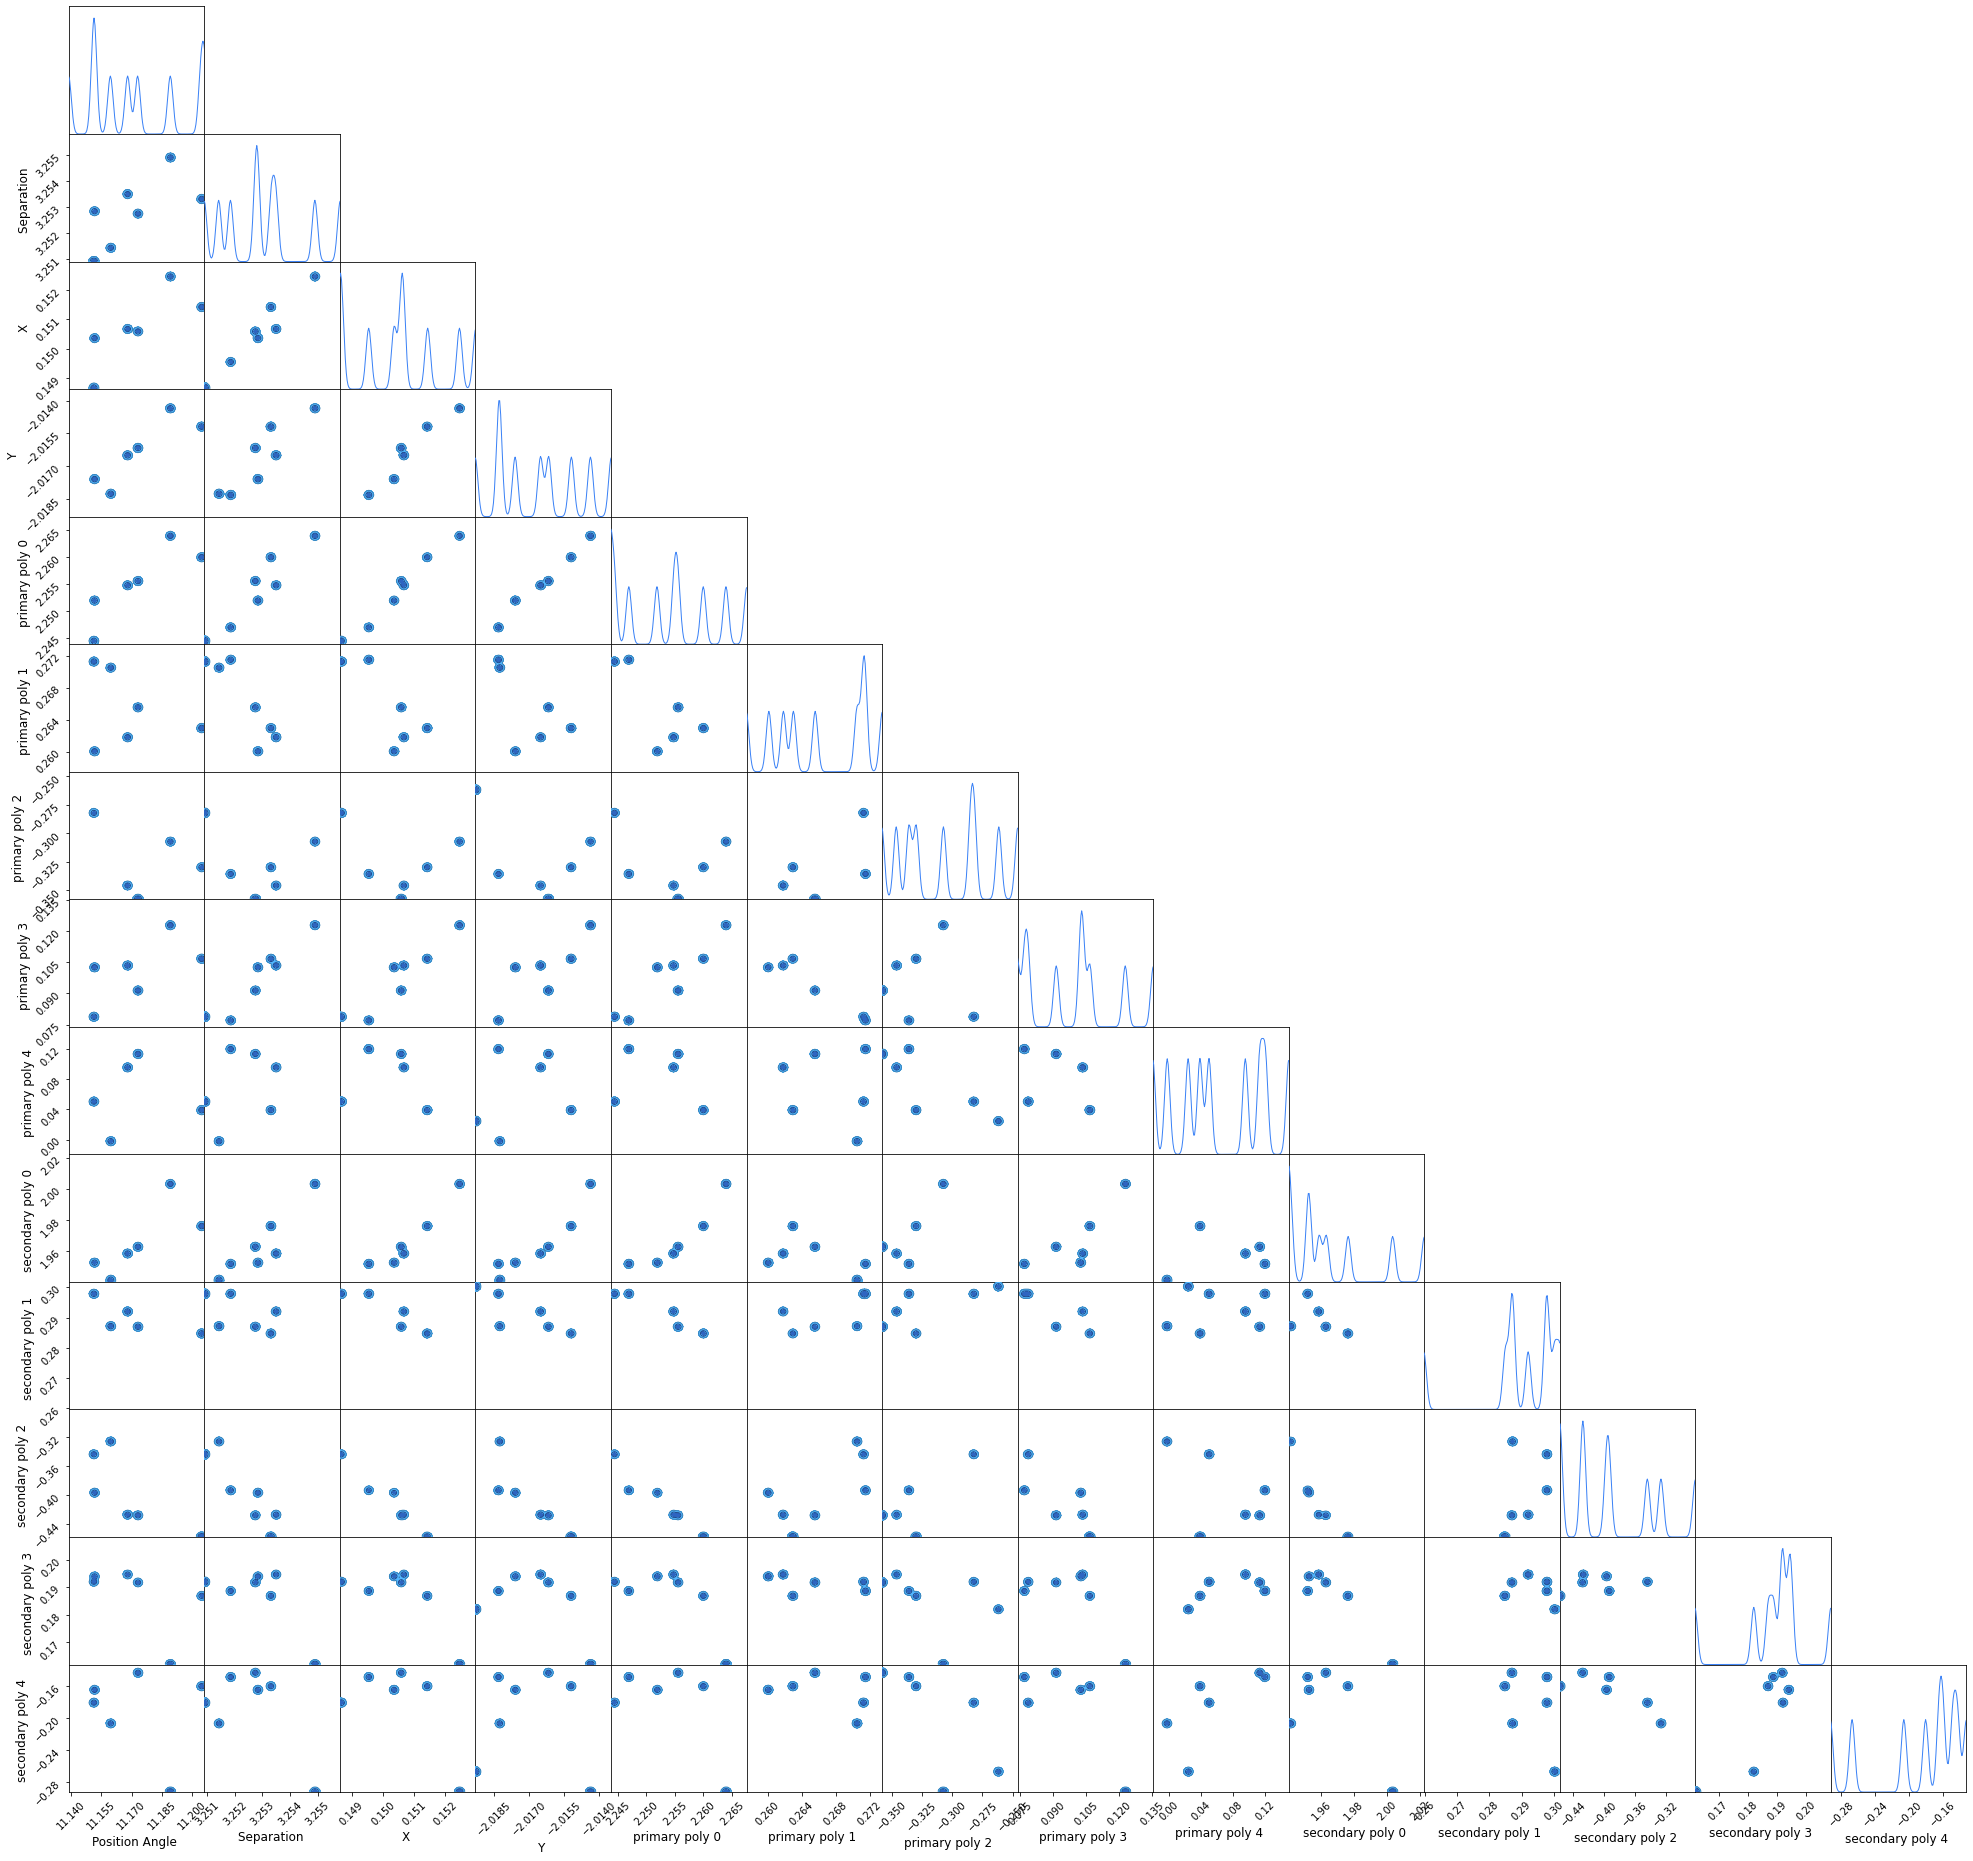

: 

In [ ]:
chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="blue", var_names=["~primary_raw", "~secondary_raw", "~position_raw", "~separation_raw", "~x_raw", "~y_raw"])
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
#fig.savefig("new_turbo_32_adj.png")
#plt.close()

plt.show()